In [220]:
using Revise
using EAMC
using Plots
using LinearAlgebra

# utility functions
linspace(x1, x2, n) = range(x1, stop=x2, length=n) |> collect
cg = cgrad(:matter, scale=:log)
hm(x; kwargs...) = heatmap(x|>collect, yflip=true, color = cg; kwargs...)

hm (generic function with 1 method)

In [502]:
beta = 1
phi = 1

nx = 5
xmax = 1.6

#nx = 3
#xmax = 1.1

nt = 4
tmax = 1
ts = linspace(0, tmax, nt+1)

process = EAMC.OverdampedLangevin(
    V = (x,t) -> beta * (x^2-1)^2,
    phi = phi,
    grid = range(-xmax,xmax, length=nx))

qs = [EAMC.generatormatrix(process, t) for t in ts];

In [503]:
g = galerkin(qs, ts);

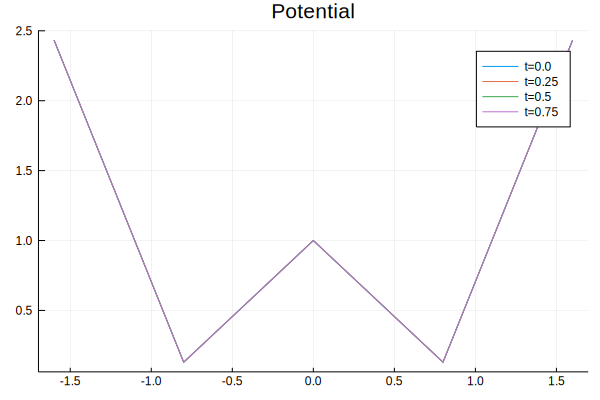

In [504]:
p=plot(title="Potential")
for t in ts[1:end-1]
    plot!(process.grid, x->process.V(x,t),label="t=$(round(t, digits=2))")
end
p

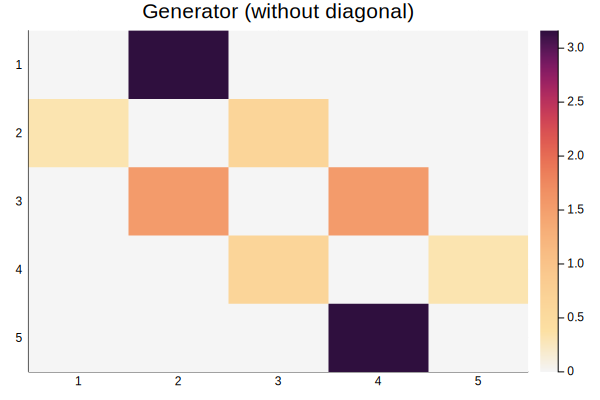

In [511]:
hm(qs[1]-Diagonal(qs[1]), title="Generator (without diagonal)")

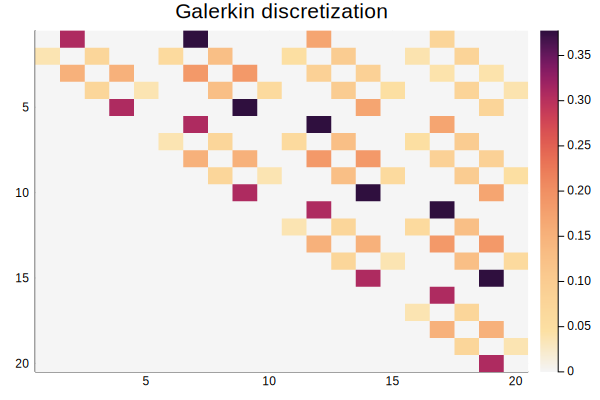

In [506]:
hm(g, color=cg, title="Galerkin discretization")

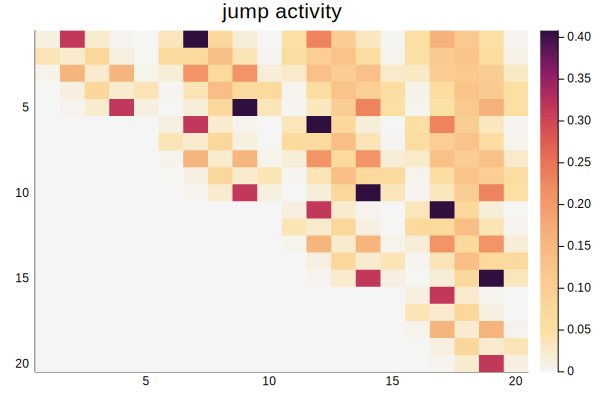

In [512]:
E = EAMC.jumpactivity(g)
hm(E, title="jump activity")

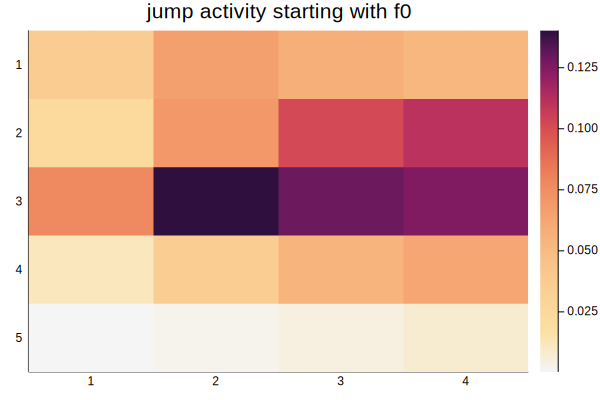

In [514]:
f0=zeros(nx)
f0[2] = 1
act = EAMC.jumpactivity(g, f0)
hm(act, title="jump activity starting with f0")

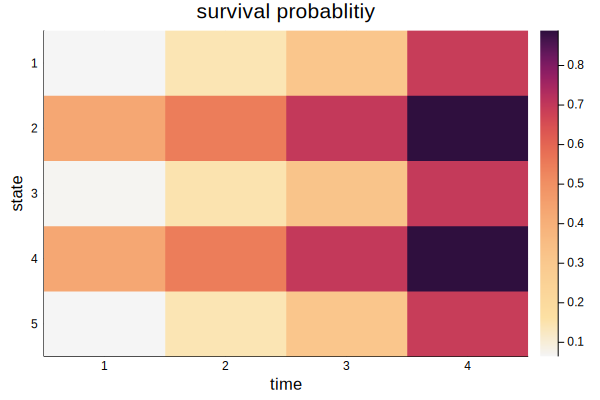

In [480]:
#survival from inside each timecell to T
qout = [collect(-diag(q)) for q in qs]
q = qout[1]
i = 4
S=zeros(nx, nt)
for i=1:nt
    S[:,i] .= 1 ./ q .*(exp.(-q*(ts[end] - ts[i+1])) - exp.(-q*(ts[end] - ts[i]))) / (ts[i+1]-ts[i])
end
hm(S, title="survival probablitiy", xlabel="time", ylabel="state")

In [456]:
# survival from 0 to T
fixture = Diagonal(exp.(-q*(ts[end] - ts[1])))

5×5 Diagonal{Float64,Array{Float64,1}}:
 0.0422346   ⋅         ⋅          ⋅         ⋅       
  ⋅         0.381693   ⋅          ⋅         ⋅       
  ⋅          ⋅        0.0454772   ⋅         ⋅       
  ⋅          ⋅         ⋅         0.381693   ⋅       
  ⋅          ⋅         ⋅          ⋅        0.0422346

In [516]:
Pf = EAMC.perronfrobenius(g, qs, ts)

5×5 Adjoint{Float64,Array{Float64,2}}:
 0.0998771   0.0669597   0.0306554  0.00737275  0.00411172
 0.669856    0.600694    0.371212   0.119839    0.0754204 
 0.128593    0.15526     0.173142   0.15526     0.128593  
 0.0754204   0.119839    0.371212   0.600694    0.669856  
 0.00411172  0.00737275  0.0306554  0.0669597   0.0998771 

In [517]:
Pf2 = exp(qs[1]|>collect)'

5×5 Adjoint{Float64,Array{Float64,2}}:
 0.103403    0.0658763   0.0331215  0.00924166  0.00544977
 0.659695    0.630145    0.375083   0.137658    0.0925475 
 0.138904    0.157079    0.183592   0.157079    0.138904  
 0.0925475   0.137658    0.375083   0.630145    0.659695  
 0.00544977  0.00924166  0.0331215  0.0658763   0.103403  

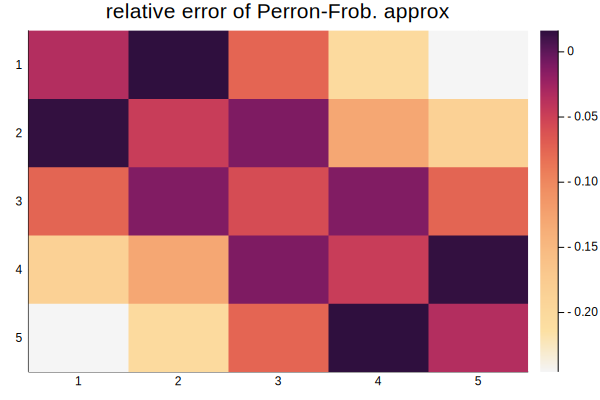

In [518]:
hm((Pf - Pf2) ./ Pf2, title="relative error of Perron-Frob. approx")